In [1]:
import csv
import numpy as np
from scipy.interpolate import griddata

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

RDKit WARNING: [16:39:06] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
from sklearn.manifold import TSNE

Load in molecular structures and inhibition constants (pIC$_{50}$) for inhibitors with known affinities against EGFR and c-MET.  These are gleaned from ChEMBL.

In [4]:
import csv
EGFR, MET = 'EGFR', 'CMET'
targets = [EGFR, MET]
data = dict( [(p, list( csv.reader( open('data/Cleaned_%s.csv' % p)))[1:]) for p in targets ])

Convert the SMILES into molecular structures and extract the pIC$_{50}$ values.

In [5]:
mols = dict([ (p, [Chem.MolFromSmiles(d[2]) for d in data[p]]) for p in targets ])
pIC50 = dict([ (p, np.array( [ d[3] for d in data[p]]).astype(float)) for p in targets ])

The number of ligands against EGFR and against c-MET.

In [6]:
[ len(mols[p]) for p in targets ]

[6923, 3265]

Compute the RDKit topological fingerprints for each molecule.

In [7]:
from itertools import chain
allmols = chain.from_iterable( [ mols[p] for p in targets ])
fps = [ Chem.RDKFingerprint( m) for m in allmols ]

Compute the pairwise similarities between the molecules using fingerprint similarity.  This takes some time.

In [8]:
from rdkit import DataStructs
import time
t0 = time.perf_counter()
sim = np.array( [[ DataStructs.FingerprintSimilarity(fps[i], fps[j]) 
                 for i in range(len(fps)) ] for j in range(len(fps)) ])
t1 = time.perf_counter()
dt = t1 - t0
print( 'Pairwise similarities computed for %d molecules in %.1f seconds' % (len(fps), dt))

Pairwise similarities computed for 10188 molecules in 308.4 seconds


Embed the molecules in a 2-dimensional plane using t-SNE.

In [9]:
from sklearn.manifold import TSNE
t0 = time.perf_counter()
embed = TSNE(n_components=2).fit_transform( sim)
t1 = time.perf_counter()
dt = t1 - t0
print( 'T-SNE embedding for %d molecules in %.1f seconds' % (sim.shape[0], dt))

T-SNE embedding for 10188 molecules in 878.6 seconds


In [10]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib
matplotlib.rcParams.update( {'font.size': 14})

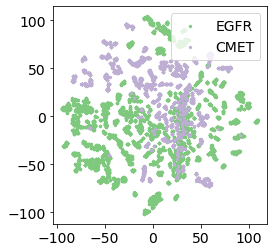

In [142]:
colors = ['#7fc97f','#beaed4','#fdc086']
fig, ax = plt.subplots()
pbeg = 0
for i, p in enumerate(targets):
    nmol = len(mols[p])
    pend = pbeg + nmol
    ax.scatter( embed[pbeg:pend, 0], embed[pbeg:pend, 1], label=p, s=10, edgecolor=colors[i], facecolor=colors[i], linewidth=0.1)
    pbeg = pend
ax.legend()
ax.set_aspect( 1)

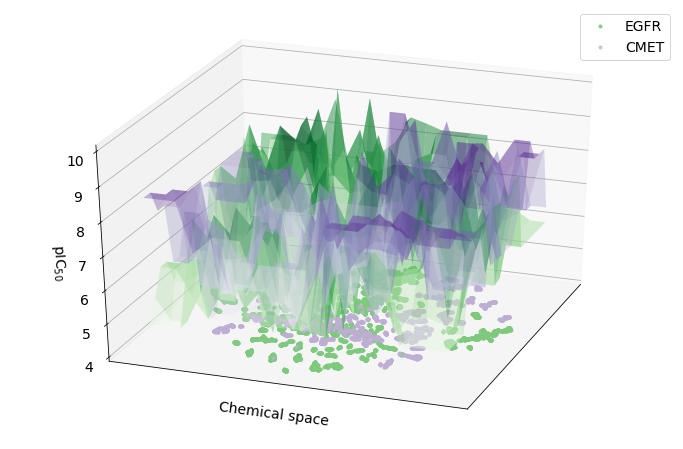

In [147]:
from scipy.interpolate import griddata

def plotIC50( xy, pIC50s, tgts, bins=20):
    cmaps = [ plt.get_cmap( c) for c in [ 'Greens', 'Purples', 'Oranges'] ]
    xmin, ymin = xy.min( axis=0)
    xmax, ymax = xy.max( axis=0)
    dx = (xmax - xmin)/bins
    dy = (ymax - ymin)/bins
    fig = plt.figure( figsize=(12, 8))
    ax = fig.gca( projection='3d')
    pbeg = 0
    pIC50min = min( [ pIC50.min() for pIC50 in pIC50s ])
    for t, pIC50 in enumerate(pIC50s):
        nligs = len(pIC50)
        pend = pbeg + nligs
        xyligs = xy[pbeg:pend]
        ax.plot( xyligs[:,0], xyligs[:,1], pIC50min, '.', color=colors[t], alpha=0.9-t*0.2, label=tgts[t])
        xygrid = np.array( [[ (xmin + (i+0.5)*dx, ymin + (j+0.5)*dy) for j in range(bins)]
                            for i in range(bins)])
        pIC50grid = griddata( xyligs, pIC50, xygrid, method='nearest', fill_value=np.mean(pIC50))
        ax.plot_surface( xygrid[:,:,0], xygrid[:,:,1], pIC50grid, cmap=cmaps[t],
                         alpha=0.5-t*0.2)
        pbeg = pend
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel( 'Chemical space')
    ax.set_zlabel( r'pIC$_{50}$')
    ax.view_init( 30, 20)
    ax.legend()
    return fig

fig0 = plotIC50( embed, [ pIC50[t] for t in targets ], targets)

In [12]:
from sklearn.neighbors import KDTree

def envelope( xy, f, bins=20, xybounds=None):
    '''
    For each point xy and its functional value f(x,y), calculate the maximum of the function in a d-neighborhood of xy:
    fmax(x, y) = max{ f(r) | |r - (x,y)| < d }
    
    Arguments:
    
    xy: K x 2 array, the coordinates of the 2-dimensional embeddings of K points.
    
    f: length K array, f[i] is the functional value of the i'th point.
    
    bins: integer, the number of bins to divide the embedding space into bins x bins neighborhoods
    
    xybounds: (( xmin, xmax ), (ymin, ymax)), the optional bounds of the chemical space of interest
    
    Returns:
    
    fmax: length K array, the maximum functional values in the neighborhood of each point.
    
    xygrid: bins x bins x 2 array, grid points on which the fmax will be interpolated on.
    
    fmaxgrid: length bins^2 array, the interpolated values of fmax on the grid of xygrid.  This smoothes the envelope.
    
    '''
    if xybounds is None:
        xmin, ymin = xy.min( axis=0)
        xmax, ymax = xy.max( axis=0)
    else:
        (xmin, xmax), (ymin, ymax) = xybounds
        
    dx = (xmax - xmin)/bins
    dy = (ymax - ymin)/bins
    dl = max( dx, dy)
    kdt = KDTree( xy, leaf_size=30, metric='euclidean')
    nn = kdt.query_radius( xy, dl)
    
    fmin = np.min( f)
    fmax = np.zeros( len(f))
    for i, fi in enumerate(f):
        fimax = np.max( [ f[j] for j in nn[i] ])
        fmax[i] = max( fimax, fi)
    
    xygrid = np.array( [[ (xmin + (i+0.5)*dx, ymin + (j+0.5)*dy) for j in range(bins)]
                        for i in range(bins)])
    fmaxgrid = griddata( xy, fmax, xygrid, method='nearest', fill_value=np.mean(f))
    return fmax, xygrid, fmaxgrid

In [13]:
def plotIC50envelope( xy, pIC50s, tgts):
    cmaps = [ plt.get_cmap( c) for c in [ 'Greens', 'Purples', 'Oranges'] ]
    fig = plt.figure( figsize=(12, 8))
    ax = fig.gca( projection='3d')
    pbeg = 0
    pIC50min = min( [ pIC50.min() for pIC50 in pIC50s ])
    for t, pIC50 in enumerate(pIC50s):
        nligs = len(pIC50)
        pend = pbeg + nligs
        xyligs = xy[pbeg:pend]
        pIC50max, xygrid, pIC50maxgrid = envelope( xyligs, pIC50)
        ax.plot( xyligs[:,0], xyligs[:,1], pIC50min, '.', color=colors[t], alpha=0.9-t*0.2, label=tgts[t])
        ax.plot_surface( xygrid[:,:,0], xygrid[:,:,1], pIC50maxgrid, cmap=cmaps[t],
                        alpha=0.5-t*0.2)
        pbeg = pend
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel( 'Chemical space')
    ax.set_zlabel( r'pIC$_{50}$')
    ax.view_init( 30, 20)
    ax.legend()
    return fig

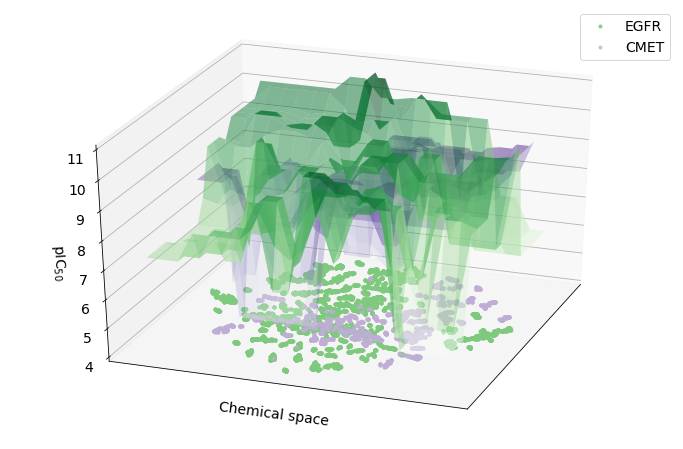

In [14]:
fig = plotIC50envelope( embed, [ pIC50[t] for t in targets ], targets)

Next, let's add to the plot ligands with measured affinities against both EGFR and c-MET.

In [15]:
from functools import reduce
chembl = [ [ d[1] for d in data[p] ] for p in targets ]
chemblDualKIs = reduce( lambda x, y: set(x).intersection( set(y)), chembl)
chemblDualKIs = list( chemblDualKIs)
chembl2id = dict([ (p, dict( [(d[1], i) for i, d in enumerate(data[p])])) for p in targets ])
pIC50dualKIs = np.array( [ tuple( [ pIC50[p][chembl2id[p][c]] for p in targets ]) for c in chemblDualKIs ])
embedDualKIs = embed[[chembl2id[targets[0]][c] for c in chemblDualKIs]]

In [16]:
len(chemblDualKIs)

59

In [17]:
pIC50min = min( [ pIC50[p].min() for p in targets ])

In [18]:
def plotDualIC50( embed, pIC50s, pIC50min, fig):
    ax = fig.gca()
    ax.scatter( embed[:,0], embed[:,1], pIC50min, 'o', s=80, 
                facecolors='yellow', edgecolors='red')

    for i in range(len(embed)):
        ax.plot( [ embed[i,0], embed[i,0] ],
                 [ embed[i,1], embed[i,1] ],
                 pIC50s[i], '-', color='r' )
        ax.scatter( embed[i,0], embed[i,1], pIC50s[i,0], 'o', label='EGFR', 
                   s=80, color='green', edgecolors='r')
        ax.scatter( embed[i,0], embed[i,1], pIC50s[i,1], 'o', label='MET',
                   s=80, color='purple', edgecolors='r')
    return fig

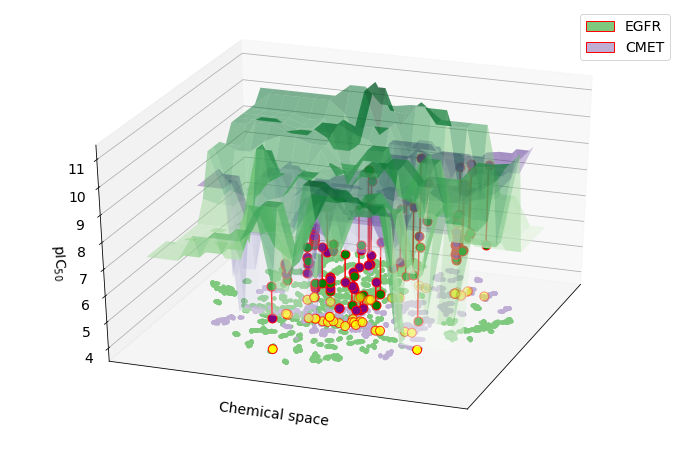

In [19]:
fig = plotDualIC50( embedDualKIs, pIC50dualKIs, pIC50min, fig)
from matplotlib.patches import Patch
legends = [ Patch(facecolor=c, edgecolor='red', label=t) for c, t in zip( colors[:len(targets)], targets) ]
fig.gca().legend( handles=legends)
fig

The "dual" inhibitors are highlighted in yellow and their EGFR/c-MET pIC$_{50}$ values are indicated with the red lines.

In [20]:
fig.savefig( 'dual-KI-space.pdf')

If we are looking for dual inhibitors, we would like to search in the chemical space where pIC$_50$ envelope is high for both EGFR and c-MET.  In other words, we want to find the region where min( pIC$_{50, max}^{(\mathrm{EGFR})}$, pIC$_{50,max}^{(\mathrm{c-MET})}$) is large. 

In [21]:
def multispecificpIC50Max( xy, pIC50s):
    '''
    Estimate the potential to identify multispecific inhibitors in each region in the chemical space.  The chemical
    space is partitioned into regions and a multispecific potential is computed for each region:
    
    pIC50minmax[r] = min( [ pIC50max[t][r] for t in targets ] )
    '''
    xmin, ymin = xy.min( axis=0)
    xmax, ymax = xy.max( axis=0)

    pbeg = 0
    pIC50minmax = None
    for t, pIC50 in enumerate(pIC50s):
        nligs = len(pIC50)
        pend = pbeg + nligs
        xyligs = xy[pbeg:pend]
        pIC50max, xygrid, pIC50maxgrid = envelope( xyligs, pIC50, xybounds=((xmin, xmax), (ymin, ymax)))
        if pIC50minmax is None:
            pIC50minmax = pIC50maxgrid
        else:
            pIC50minmax = np.min( [ pIC50minmax, pIC50maxgrid ], axis=0)
        pbeg = pend    
        
    return xygrid, pIC50minmax

In [22]:
xygrid, pIC50minmax = multispecificpIC50Max( embed, [ pIC50[p] for p in targets ])

In [81]:
pIC50cut = 9.
def plotpIC50minmax( xygrid, pIC50minmax, pIC50min, pIC50cut=pIC50cut):
    fig = plt.figure( figsize=(12, 8))
    ax = fig.gca( projection='3d')
    cmap = plt.get_cmap( 'Oranges')
    ax.plot_surface( xygrid[:,:,0], xygrid[:,:,1], pIC50minmax, alpha=0.5, cmap=cmap)
    dx, dy = xygrid[1,1] - xygrid[0,0]
    high = xygrid[ pIC50minmax > pIC50cut]
    for x, y in high:
        ax.plot_surface( np.array([ [x - 0.5*dx, x + 0.5*dx], [x - 0.5*dx, x + 0.5*dx] ]),
                         np.array([ [y - 0.5*dy, y - 0.5*dy], [y + 0.5*dy, y + 0.5*dy] ]), 
                         np.array([ [pIC50min, pIC50min], [pIC50min, pIC50min] ]), color='orange', alpha=0.9)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel( 'Chemical space')
    ax.set_zlabel( r'pIC$_{50}$')
    ax.view_init( 30, 20)
    return fig

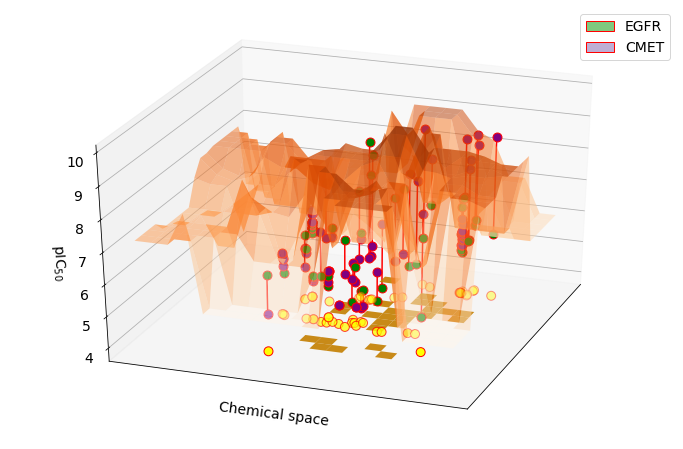

In [117]:
fig2 = plotpIC50minmax( xygrid, pIC50minmax, pIC50min)
fig2 = plotDualIC50( embedDualKIs, pIC50dualKIs, pIC50min, fig2)
fig2.gca().legend( handles=legends)

In [82]:
dx, dy = xygrid[1,1] - xygrid[0,0]
xyhigh = xygrid[ pIC50minmax>pIC50cut]

In [103]:
molhigh = [ list(np.arange( len(embed))[np.all(np.abs(embed - xy) < (0.5*dx, 0.5*dy), axis=1)]) for xy in xyhigh ]

In [104]:
molhigh = list(reduce( lambda x, y: set(x).union(set(y)), molhigh))

In [119]:
def plotHighPotentialMols( xy, mols, pIC50min, fig):
    ax = fig.gca()
    ax.scatter( xy[mols,0], xy[mols,1], pIC50min, s=50, facecolors='orange', edgecolors='red')
    return fig

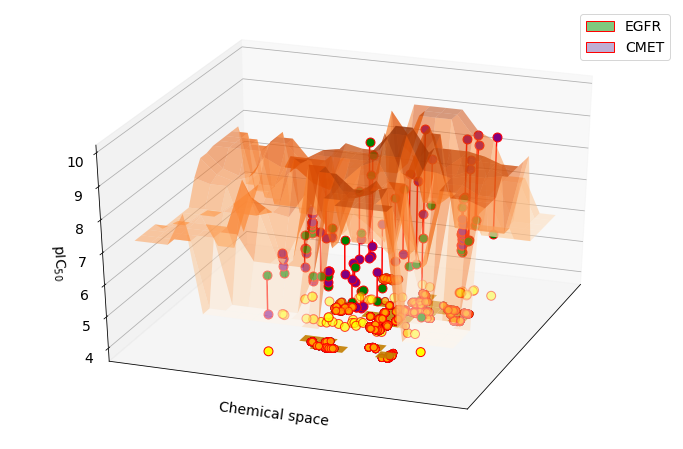

In [120]:
fig2 = plotHighPotentialMols( embed, molhigh, pIC50min, fig2)
fig2

/Users/huafengxu/anaconda3/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 60. Change the maxMols value to display more.
  warnings.warn(


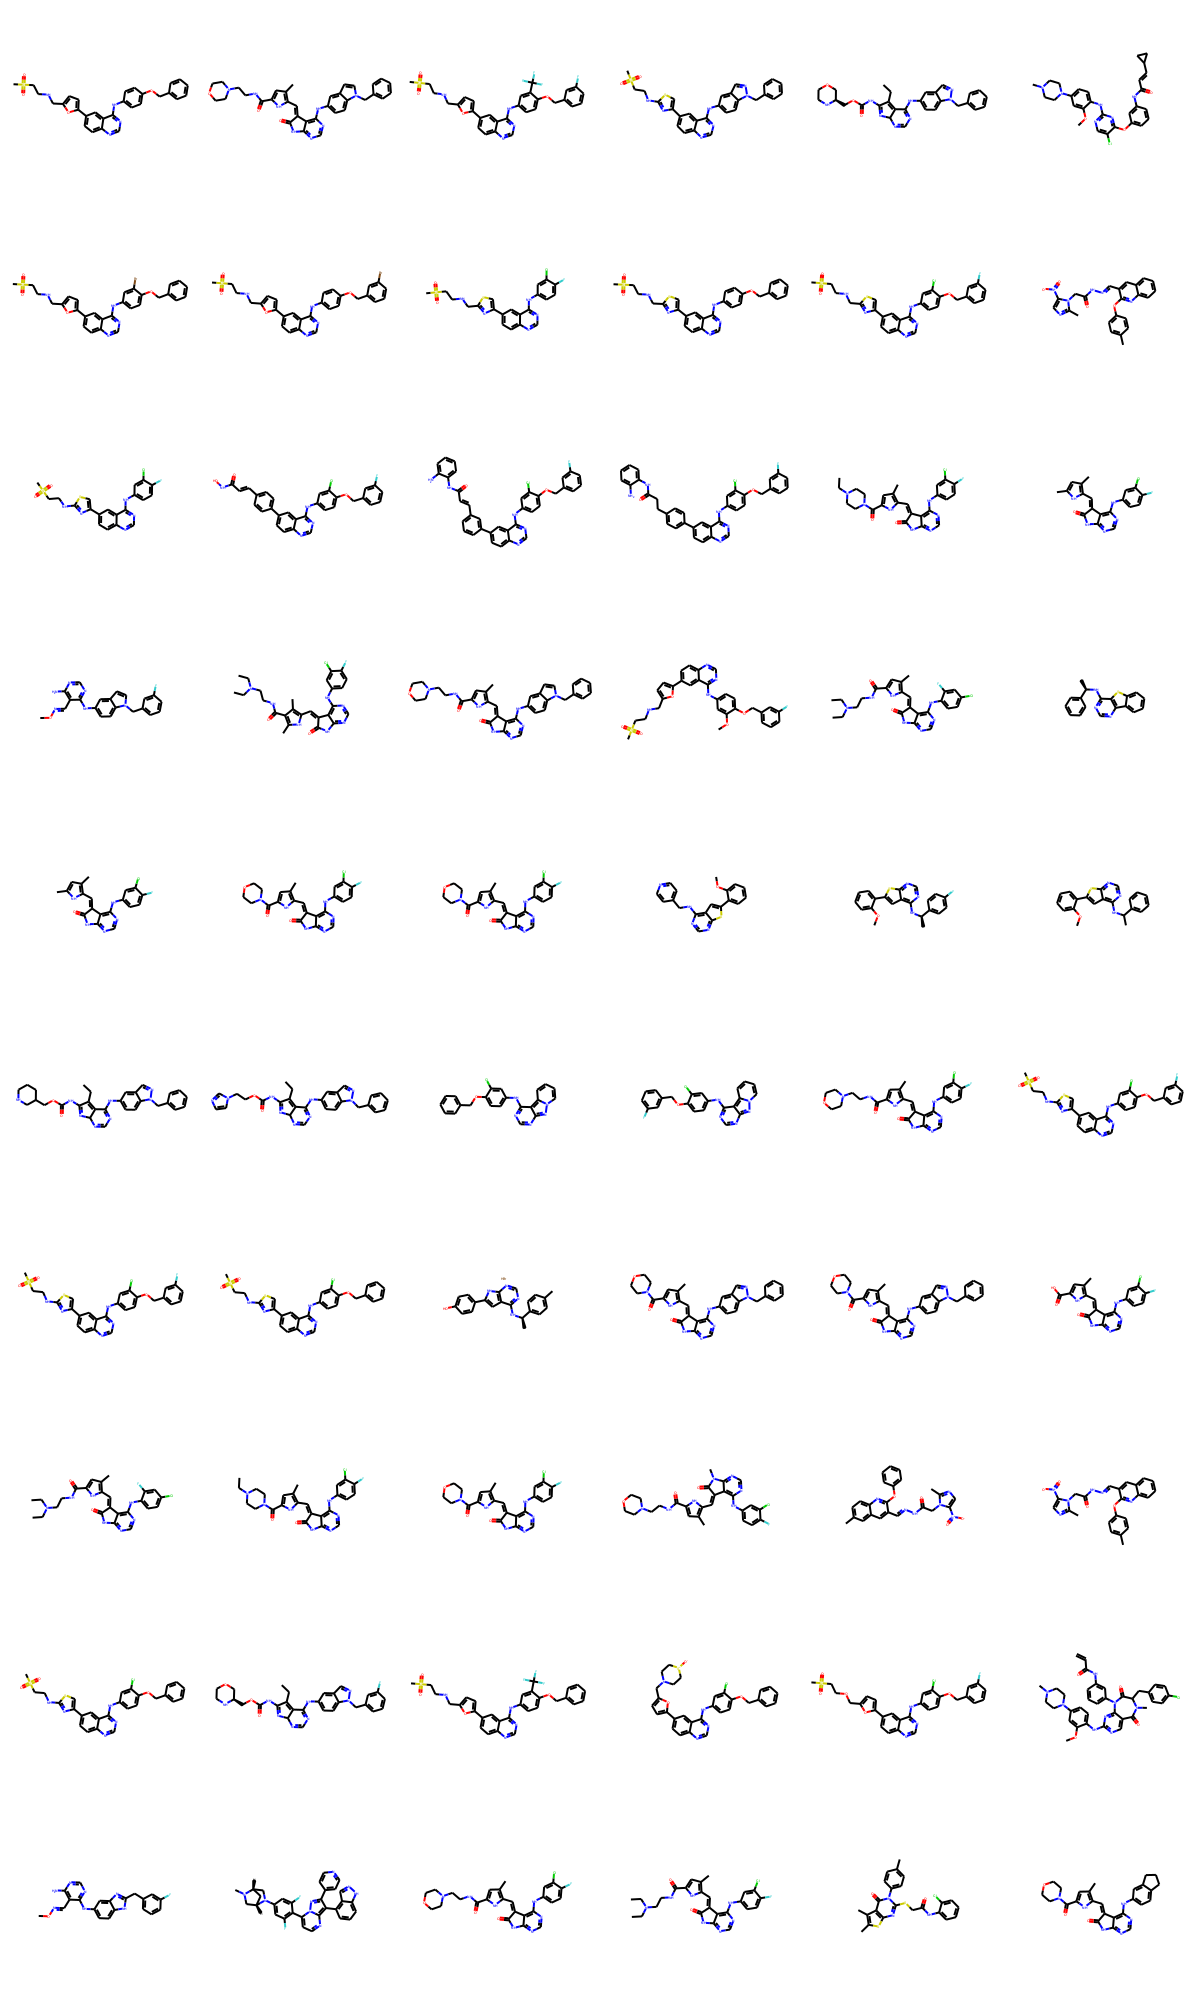

In [139]:
from rdkit.Chem import Draw
allmols = list(chain.from_iterable( [ mols[p] for p in targets ]))
Draw.MolsToGridImage( [m for i, m in enumerate(allmols) if i in molhigh], molsPerRow=6, maxMols=60)